In [1]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from refiners.fluxion.utils import manual_seed, no_grad
from anydoor_refiners.preprocessing import preprocess_images
from anydoor_refiners.postprocessing import post_processing
from anydoor_refiners.model import AnyDoor


torch.set_num_threads(2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float16

In [2]:
model = AnyDoor(device=device,dtype=dtype)
model.unet.load_from_safetensors("ckpt/refiners/unet.safetensors")
model.control_model.load_from_safetensors("ckpt/refiners/controlnet.safetensors")
model.object_encoder.load_from_safetensors("ckpt/refiners/dinov2_encoder.safetensors")
model.lda.load_from_safetensors("ckpt/refiners/lda_new.safetensors")
True # suppress output

True

In [3]:
seed = 42
uncod_scale = 5.0
num_inference_steps = 50
if num_inference_steps!= model.steps:
    model.set_inference_steps(num_inference_steps, first_step=0)

In [5]:
# File paths
background_image_path = 'examples/backgrounds/5.png'
background_mask_path = 'examples/background_masks/5.png'
object_image_path = 'examples/objects/5.png'

preprocessed_images = {}

for i in [1,2,3]:
    background_image_path = f'examples/backgrounds/{i}.jpg'
    background_mask_path = f'examples/background_masks/{i}.png'
    object_image_path = f'examples/objects/{i}.png'
    object_image = cv2.imread(object_image_path, cv2.IMREAD_UNCHANGED)
    object_mask = (object_image[:,:,-1] > 128).astype(np.uint8)
    object_image = object_image[:,:,:-1]
    object_image = cv2.cvtColor(object_image.copy(), cv2.COLOR_BGR2RGB)
    background_image = cv2.imread(background_image_path).astype(np.uint8)
    background_image = cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB)
    background_mask = cv2.imread(background_mask_path)[:,:,0] > 128
    background_mask = background_mask.astype(np.uint8)
    preprocessed_images[i] = preprocess_images(object_image, object_mask, background_image.copy(), background_mask)


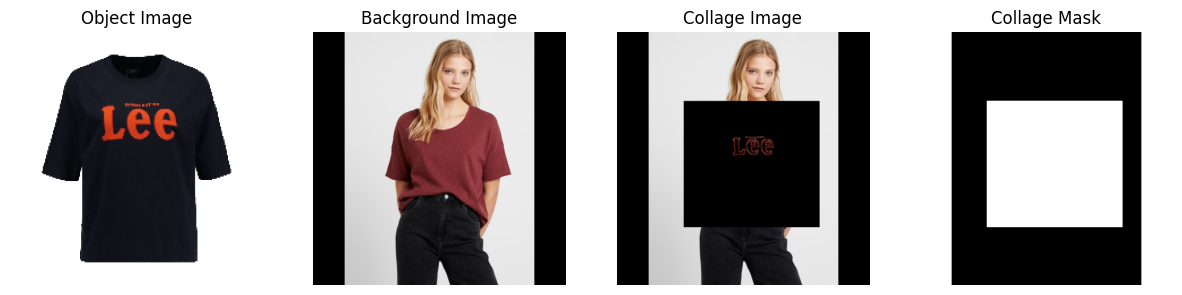

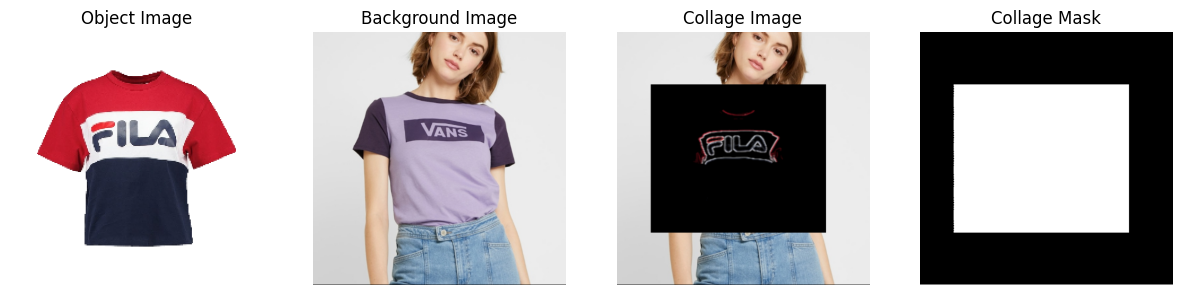

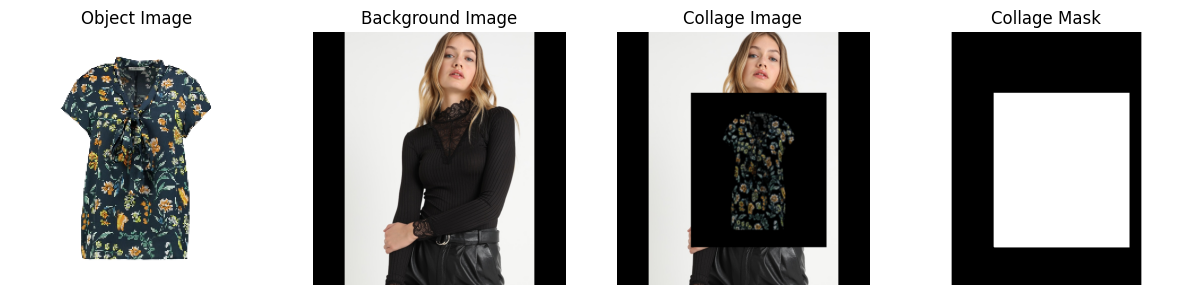

In [7]:
def display_images(images):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    for i, (title, img) in enumerate(images.items()):
        # Rescale image if it's in the range [-1, 1] to [0, 1]
        if np.min(img) < 0 or np.max(img) > 1:
            img = (img + 1) / 2  # Rescale from [-1, 1] to [0, 1]
        axs[i].imshow(img)
        axs[i].axis("off")
        axs[i].set_title(title)
    plt.show()

for i in range(1,4):

    display_images({
        "Object Image": preprocessed_images[i]["object"] ,
        "Background Image": preprocessed_images[i]["background"] ,
        "Collage Image": preprocessed_images[i]["collage"][:,:,:-1] ,
        "Collage Mask": np.stack([preprocessed_images[i]["collage"][:,:,-1]] * 3, axis=-1) ,
    })

In [13]:
control_tensors = [ torch.from_numpy(preprocessed_images[i]['collage'].copy()).to(device=device,dtype=dtype).unsqueeze(0).permute(0,3,1,2) for i in range(1,4)]
control_tensor = torch.cat(control_tensors, dim=0)
object_tensors = [ torch.from_numpy(preprocessed_images[i]['object'].copy()).to(device=device,dtype=dtype).unsqueeze(0).permute(0,3,1,2) for i in range(1,4)]
object_tensor = torch.cat(object_tensors, dim=0)

In [14]:
control_tensor.shape, object_tensor.shape

(torch.Size([3, 4, 512, 512]), torch.Size([3, 3, 224, 224]))

In [15]:
with no_grad():  
    manual_seed(seed)
    object_embedding = model.object_encoder.forward(object_tensor)
    negative_object_embedding = model.object_encoder.forward(torch.zeros((3, 3, 224, 224),device=device,dtype=dtype))
    x = model.sample_noise((3,4,512//8, 512//8), device=device, dtype=dtype)

    for step in tqdm(model.steps):
        x = model.forward(
            x,
            step=step,
            control_background_image= control_tensor,
            object_embedding= object_embedding,
            negative_object_embedding= negative_object_embedding,
            condition_scale= 5.0
        )
    
    predicted_images = {}
    for i in range(3):
        predicted_images[i] = model.lda.latents_to_image(x[i].unsqueeze(0))



100%|██████████| 50/50 [00:08<00:00,  5.93it/s]


In [21]:
import numpy as np
final_images = []
for i in range(1,4):
    background_image_path = f'examples/backgrounds/{i}.jpg'
    background_image = cv2.imread(background_image_path).astype(np.uint8)
    background_image = cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB)
    final_images += [post_processing(np.array(predicted_images[i-1]),background_image,preprocessed_images[i]["sizes"].tolist(),preprocessed_images[i]["background_box"].tolist())]

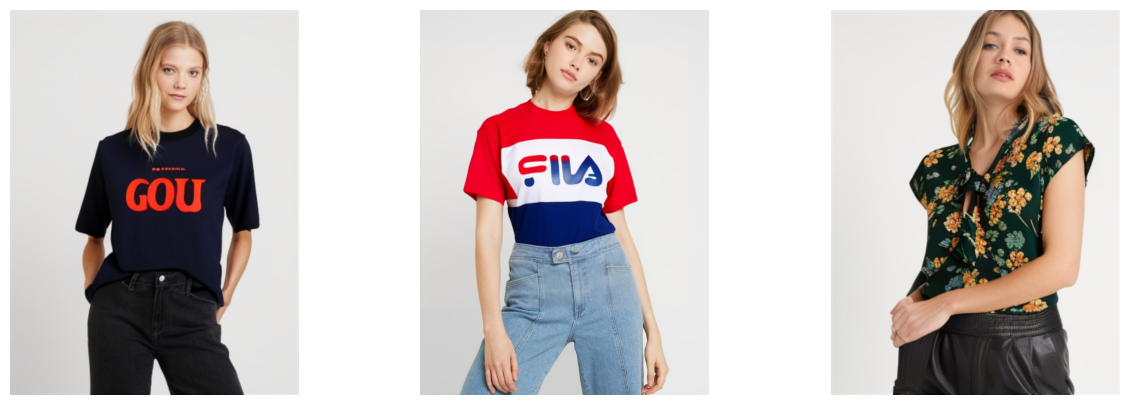

In [23]:
# Display the final images with imshow
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, img in enumerate(final_images):
    axs[i].imshow(img)
    axs[i].axis("off")
plt.show()

In [3]:
preprocessed_images["sizes"].tolist()

[512, 512, 512, 512]

In [ ]:
plt.imshow(generated_image)

In [ ]:
# Save the generated image
cv2.imwrite("examples/generated_image.png", cv2.cvtColor(generated_image, cv2.COLOR_RGB2BGR))